# Analysis of fcHNN convergence properties of the empirical connectome
### as contrasted to permutation-based null models

In [11]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
from sklearn.preprocessing import StandardScaler
import nilearn
from tqdm import tqdm
from connattractor import network, analysis
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 1
%aimport connattractor.network
%aimport connattractor.analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
connfile = '../data_in/ex_connectome_partial_correlation.csv'

mtx = pd.read_csv(connfile).iloc[:, 1:]
mtx

,CER6_p,CER7ab,R_CERCR2_p,CER9_v,CER6_a,L_CERCR2_a,CER9_d,CER9_m,CER7b_m,L_CERCR2_p,...,LVISnet_vp,MVISnet_p,MVISnet_av,LVISnet_p,PVISnet_dm,PVISnet_vm,MVISnet_ad,VVISnet_l,LVISnet_DP,VVISnet_m
0,1.000000,0.023502,0.136701,0.008193,0.074264,0.021580,0.170827,0.028969,0.015883,0.130981,...,-0.002248,-0.008683,0.000152,0.035482,0.007705,-0.029055,0.009439,-0.001390,0.009582,0.007318
1,0.023502,1.000000,0.008167,0.024126,0.046648,0.050263,0.010915,0.070042,0.085829,-0.018248,...,0.033791,0.004000,0.011493,0.007582,-0.026080,0.008013,-0.009007,0.009144,0.001391,0.012831
2,0.136701,0.008167,1.000000,0.005056,0.062669,0.028488,0.041643,0.045169,0.112164,0.157129,...,-0.003300,0.016258,-0.011801,-0.001794,-0.000603,0.012350,-0.002757,-0.004949,-0.004858,-0.000633
3,0.008193,0.024126,0.005056,1.000000,-0.020494,-0.008721,-0.004522,0.203525,-0.003757,0.019182,...,0.021645,0.000472,-0.003774,0.003395,-0.032710,-0.015305,0.007360,0.004044,-0.011696,-0.001293
4,0.074264,0.046648,0.062669,-0.020494,1.000000,0.080293,0.024584,0.002491,-0.021720,0.042291,...,-0.020753,0.005295,-0.012844,-0.014833,0.009989,0.024167,-0.005186,-0.016061,0.010920,-0.007650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,-0.029055,0.008013,0.012350,-0.015305,0.024167,-0.007512,0.045950,0.010056,-0.006412,-0.000421,...,0.011186,0.215436,-0.011083,-0.003814,0.163692,1.000000,0.013773,0.049101,-0.028493,0.115196
118,0.009439,-0.009007,-0.002757,0.007360,-0.005186,-0.023476,-0.004195,-0.029927,-0.023948,-0.023841,...,-0.012657,0.258308,0.091981,0.007686,-0.001867,0.013773,1.000000,-0.013407,0.017465,0.032366
119,-0.001390,0.009144,-0.004949,0.004044,-0.016061,0.004057,0.002311,-0.022643,0.001888,-0.007811,...,0.139682,-0.014010,0.077810,0.079338,0.055300,0.049101,-0.013407,1.000000,0.081084,0.162297
120,0.009582,0.001391,-0.004858,-0.011696,0.010920,0.002928,-0.001322,0.004114,-0.006720,-0.008002,...,0.066451,0.001324,-0.001214,0.115287,0.089609,-0.028493,0.017465,0.081084,1.000000,0.000165


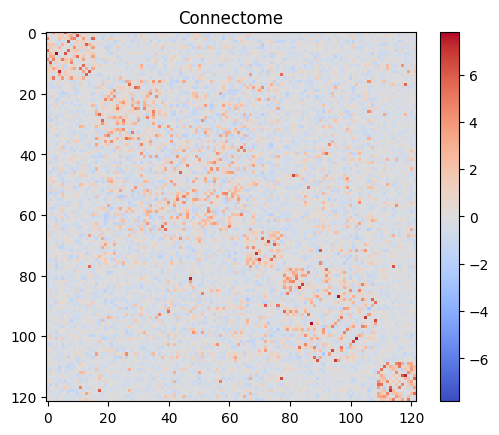

In [64]:
hopnet = network.Hopfield(mtx, scale=True)
hopnet.plot_weights()
plt.title('Connectome')
plt.show()

In [89]:
random = np.random.default_rng(42)

num_rep = 1000

num_iter_original = {}
num_iter_permuted = {}

num_iter_original[0.35] = []
num_iter_original[0.4] = []
num_iter_original[0.5] = []
num_iter_original[0.6] = []

num_iter_permuted[0.35] = []
num_iter_permuted[0.4] = []
num_iter_permuted[0.5] = []
num_iter_permuted[0.6] = []

for beta in [0.35, 0.4, 0.5, 0.6]:
    for i in tqdm(range(num_rep)):

        init_state = random.normal(size=mtx.shape[0])
        # relax from a random initial state with the original connectome
        state, num_iter, energy = hopnet.update(init_state, threshold=0, beta=beta, num_iter=10000)
        num_iter_original[beta].append(num_iter)

        # relax from the same random initial state with a permuted connectome
        permuted_mtx = mtx.values.copy()
        upper = np.triu_indices(permuted_mtx.shape[0], k=1)
        permuted_mtx[upper]=random.permutation(permuted_mtx[upper])
        # make sure it's symmetric
        for i in range(len(permuted_mtx)):
            for j in range(i):
                permuted_mtx[i,j] = permuted_mtx[j,i]
        hopnet_perm = network.Hopfield(permuted_mtx, scale=True)
        # relax from the same initial state
        state, num_iter, energy = hopnet_perm.update(init_state, threshold=0, beta=beta, num_iter=10000)
        num_iter_permuted[beta].append(num_iter)
    

100%|██████████| 100/100 [12:53<00:00,  7.73s/it]


In [96]:
print('converged in 10000 iterations')
for beta in [0.35, 0.4, 0.5, 0.6]:
    print(np.sum(np.array(num_iter_original[beta])<10000))
    print(np.sum(np.array(num_iter_permuted[beta])<10000))


print('median iterations')
for beta in [0.35, 0.4, 0.5, 0.6]:
    print(np.median(np.array(num_iter_original[beta])))
    print(np.median(np.array(num_iter_permuted[beta])))

converged in 10000 iterations
76
2
63
0
59
0
47
0
median iterations
114.5
10000.0
107.0
10000.0
134.0
10000.0
10000.0
10000.0


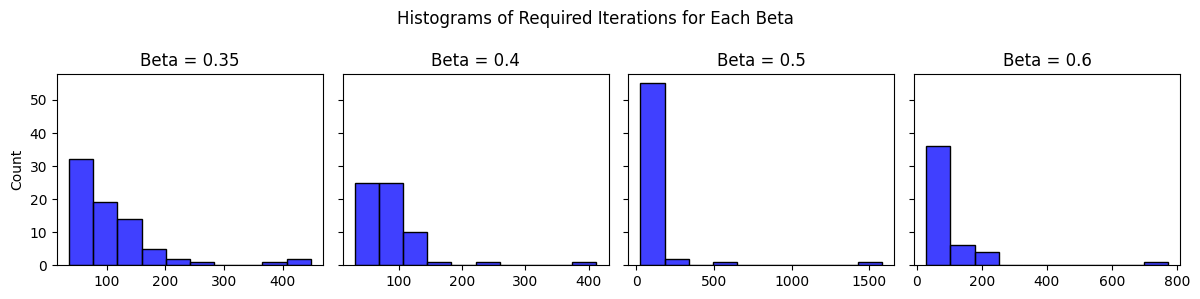

In [107]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
betas = [0.35, 0.4, 0.5, 0.6]
for i, beta in enumerate(betas):
    iternums = np.array(num_iter_original[beta])
    sns.histplot(iternums[iternums<10000], ax=axs[i], color='blue', bins=10)
    #sns.histplot(num_iter_permuted[beta], ax=axs[i], color='red', label='Permuted', alpha=0.6)
    axs[i].set_title(f'Beta = {beta}')

plt.suptitle('Histograms of Required Iterations for Each Beta')
plt.tight_layout()
plt.savefig('../docs/figures/supplement/si_convergence.png')
